Dataset Shape: (1118669, 34)


,transaction_id,order_date,customer_id,product_id,product_name,category,subcategory,brand,original_price_inr,discount_percent,...,is_festival_sale,festival_name,customer_rating,return_status,order_month,order_year,order_quarter,product_weight_kg,is_prime_eligible,product_rating
0,TXN_2015_00000001,2015-01-25,CUST_2015_00003884,PROD_000021,Samsung Galaxy S6 16GB Black,Electronics,Smartphones,Samsung,123614.29,27.91,...,True,Republic Day Sale,5.0,Delivered,1,2015,1,0.19,True,4.7
1,TXN_2015_00000002,2015-05-01,CUST_2015_00011709,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.5,Delivered,1,2015,1,0.20,True,4.1
2,TXN_2015_00000003,2015-01-24,CUST_2015_00004782,PROD_000039,Samsung Galaxy Note 5 64GB Black,Electronics,Smartphones,Samsung,97644.25,46.93,...,True,Republic Day Sale,NaN,Delivered,1,2015,1,0.17,True,3.3
3,TXN_2015_00000004,2015-01-28,CUST_2015_00008105,PROD_000085,Motorola Moto G (3rd Gen) 16GB Black,Electronics,Smartphones,Motorola,21947.26,0.00,...,False,NaN,3.0,Delivered,1,2015,1,0.22,True,3.5
4,TXN_2015_00000005,2015-01-31,CUST_2015_00002955,PROD_000055,OnePlus OnePlus 2 16GB White,Electronics,Smartphones,OnePlus,54731.86,0.00,...,False,NaN,4.0,Delivered,1,2015,1,0.20,True,4.1


----- CUSTOMER JOURNEY & LOYALTY EVOLUTION -----


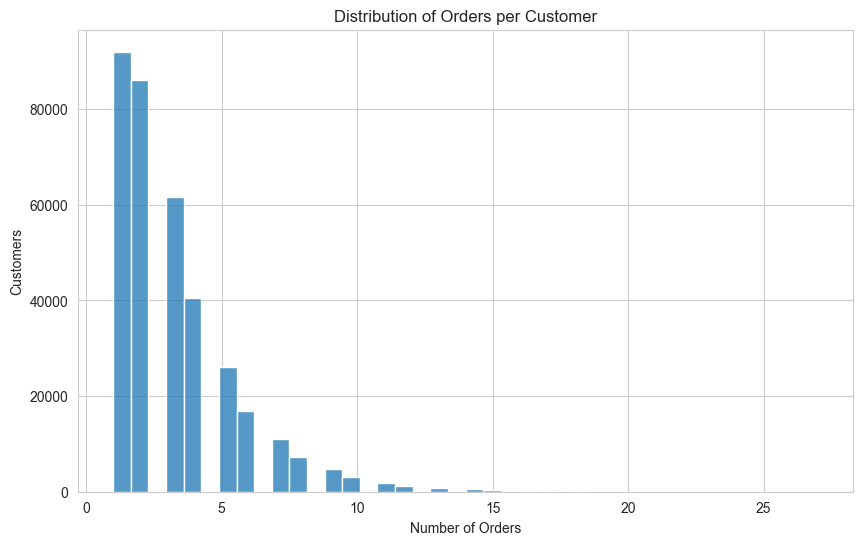

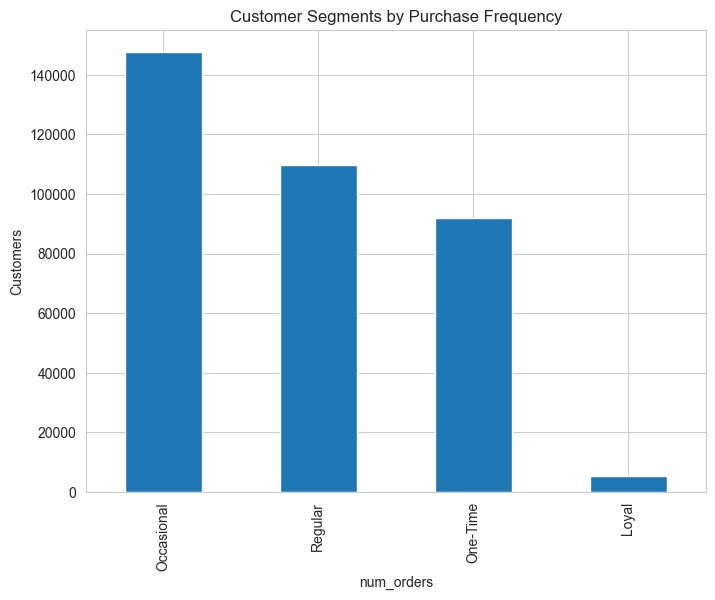

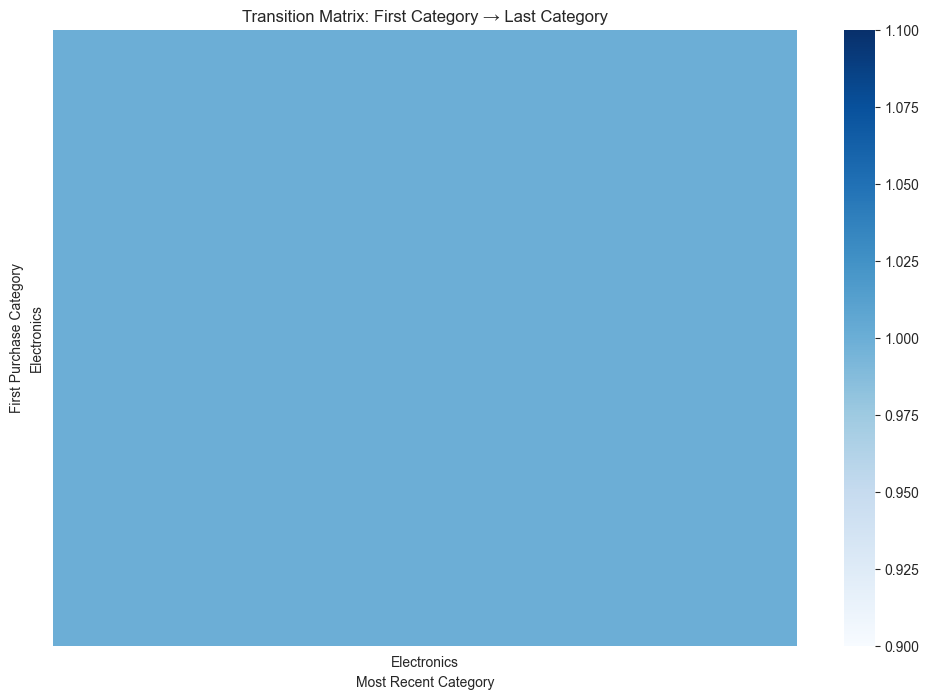

ModuleNotFoundError: No module named 'plotly'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# ============================================================
# LOAD MASTER DATA
# ============================================================

df = pd.read_csv("../master/amazon_india_master_2015_2025.csv")

print("Dataset Shape:", df.shape)
display(df.head())

# ============================================================
# BASIC CLEAN
# ============================================================

df["order_date"] = pd.to_datetime(df["order_date"], errors="coerce")

df = df.dropna(
    subset=[
        "customer_id",
        "order_date",
        "category",
    ]
)

# ============================================================
# QUESTION 17 : CUSTOMER JOURNEY ANALYSIS
# ============================================================

print("----- CUSTOMER JOURNEY & LOYALTY EVOLUTION -----")

# ------------------------------------------------------------
# PURCHASE FREQUENCY PER CUSTOMER
# ------------------------------------------------------------

cust_freq = (
    df.groupby("customer_id")["transaction_id"]
      .nunique()
      .rename("num_orders")
)

plt.figure(figsize=(10,6))
sns.histplot(cust_freq, bins=40)
plt.title("Distribution of Orders per Customer")
plt.xlabel("Number of Orders")
plt.ylabel("Customers")
plt.show()

# ------------------------------------------------------------
# CUSTOMER SEGMENTS BY ORDER COUNT
# ------------------------------------------------------------

def segment_orders(x):
    if x == 1:
        return "One-Time"
    elif x <= 3:
        return "Occasional"
    elif x <= 10:
        return "Regular"
    else:
        return "Loyal"

cust_segment = cust_freq.apply(segment_orders)

segment_dist = cust_segment.value_counts()

plt.figure(figsize=(8,6))
segment_dist.plot(kind="bar")
plt.title("Customer Segments by Purchase Frequency")
plt.ylabel("Customers")
plt.show()

# ------------------------------------------------------------
# FIRST PURCHASE CATEGORY
# ------------------------------------------------------------

df_sorted = df.sort_values(["customer_id","order_date"])

first_cat = (
    df_sorted.groupby("customer_id")
    .first()["category"]
)

# ------------------------------------------------------------
# MOST RECENT CATEGORY
# ------------------------------------------------------------

last_cat = (
    df_sorted.groupby("customer_id")
    .last()["category"]
)

journey_df = pd.DataFrame({
    "first_category": first_cat,
    "last_category": last_cat,
    "num_orders": cust_freq
})

# ------------------------------------------------------------
# TRANSITION MATRIX: FIRST -> LAST CATEGORY
# ------------------------------------------------------------

transition = pd.crosstab(
    journey_df["first_category"],
    journey_df["last_category"],
    normalize="index"
)

plt.figure(figsize=(12,8))
sns.heatmap(transition, cmap="Blues")
plt.title("Transition Matrix: First Category → Last Category")
plt.ylabel("First Purchase Category")
plt.xlabel("Most Recent Category")
plt.show()

# ------------------------------------------------------------
# CATEGORY SEQUENCE PER CUSTOMER (TOP 8)
# ------------------------------------------------------------

top_categories = df["category"].value_counts().head(8).index

flows = []

for cid, group in df_sorted[df_sorted["category"].isin(top_categories)].groupby("customer_id"):
    seq = group["category"].tolist()
    if len(seq) > 1:
        flows.append(seq[:3])   # first 3 steps

flow_df = pd.DataFrame(flows, columns=["step1","step2","step3"]).dropna()

# ------------------------------------------------------------
# SANKEY DIAGRAM
# ------------------------------------------------------------

import plotly.graph_objects as go

all_nodes = pd.unique(flow_df[["step1","step2","step3"]].values.ravel())
node_map = {v:i for i,v in enumerate(all_nodes)}

sources = []
targets = []
values = []

def add_links(df, s_col, t_col):
    links = df.groupby([s_col,t_col]).size()
    for (s,t),v in links.items():
        sources.append(node_map[s])
        targets.append(node_map[t])
        values.append(v)

add_links(flow_df,"step1","step2")
add_links(flow_df,"step2","step3")

fig = go.Figure(
    go.Sankey(
        node=dict(
            label=list(node_map.keys())
        ),
        link=dict(
            source=sources,
            target=targets,
            value=values
        )
    )
)

fig.update_layout(title_text="Customer Category Journey Flow (Top Categories)")
fig.show()

# ------------------------------------------------------------
# LOYALTY EVOLUTION OVER TIME
# ------------------------------------------------------------

df_sorted["order_rank"] = (
    df_sorted.groupby("customer_id")
      .cumcount() + 1
)

df_sorted["loyalty_stage"] = pd.cut(
    df_sorted["order_rank"],
    bins=[0,1,3,10,1000],
    labels=["First-Time","Occasional","Regular","Loyal"]
)

loyalty_dist = (
    df_sorted.groupby("loyalty_stage")["customer_id"]
      .nunique()
)

plt.figure(figsize=(8,6))
loyalty_dist.plot(kind="bar")
plt.title("Customers by Loyalty Stage")
plt.ylabel("Unique Customers")
plt.show()

# ------------------------------------------------------------
# CATEGORY MIX BY LOYALTY STAGE
# ------------------------------------------------------------

loyal_cat = pd.crosstab(
    df_sorted["loyalty_stage"],
    df_sorted["category"],
    normalize="index"
)

plt.figure(figsize=(12,6))
sns.heatmap(loyal_cat, cmap="YlGnBu")
plt.title("Category Preference by Loyalty Stage")
plt.show()

print("✅ EDA_12 COMPLETED SUCCESSFULLY")
